#***What is this Notebook all About?***
> "Stock Price Forecasting Based On Macroeconomic Factor Using LSTM Architecture"
*   **Source of Datasets** | https://www.investing.com/
*   *I do the stock forecasting with various timestep and parameter. The parameters i used are given value and will be mentioned in Model Construction section, Meanwhile the timesteps are experimental-based which starts from 1. I collect the best model for every timestep, which every timestep has 324 models by tuning parameter, once the best model for the next 2 timestep are increasing, the experiment will stops.*
* *My Forecasting Result Summary can be seen Below, it requires 3564 models. So the terms 'Univariate' requires the previous day's stock value, Meanwhile, 'Multivariate' requires the previous day's stock and exchange value*

> ![alt text](https://drive.google.com/uc?id=1kUZSPodPc2l5Py4tR502niaLX8MIQ3t6) : 

* *Finally based on my Experiments,*
* **Univariate stops at 7 which its best model has 1.3465 MAPE, while**
* **Multivariate stops at 4 which its best model has 1.3512 MAPE.**

# ***Mount Drive***

* **Make Drive Directory Visible**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***Load Libraries***

* **Libraries for Wrangling, Visualizing, Scaling, etc**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time 

from numpy import hstack 
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


* **Libraries for Modeling using LSTM**

In [0]:
from tensorflow.python.keras import Sequential      #Create Sequential Layer
from tensorflow.python.keras.layers import LSTM     #Create LSTM Layer
from tensorflow.python.keras.layers import GRU      #Create GRU Layer / Scenario
from tensorflow.python.keras.layers import Dense    #Create Output Layer
from tensorflow.python.keras.layers import Dropout  #Create Regularization

* **Determine Open/Save Directory**

In [0]:
pathDatasets = '/content/drive/My Drive/Colab/College - Final Projects/Datasets/' #Getting Datasets
pathResults = '/content/drive/My Drive/Colab/College - Final Projects/Results/' #Saving Excel, Image, etc

# ***Getting Datasets***

* **Load Data**

In [0]:
dataset_Kurs = pd.read_csv(pathDatasets + 'USD_IDR.csv', thousands= ",")      #Predictor
dataset_ASII = pd.read_csv(pathDatasets + 'Stock ASII.csv', thousands = ",")  #Regresor (Main)
dataset_KAEF = pd.read_csv(pathDatasets + 'Stock KAEF.csv', thousands = ",")  #Regresor (Scenario)
dataset_SMGR = pd.read_csv(pathDatasets + 'Stock SMGR.csv', thousands = ",")  #Regresor (Scenario)
dataset_ASII


,Date,Price,Open,High,Low,Vol.,Change %
0,"Sep 30, 2019",6600,6650,6675,6575,21.09M,-0.75%
1,"Sep 27, 2019",6650,6700,6700,6600,9.83M,-0.75%
2,"Sep 26, 2019",6700,6575,6700,6525,37.98M,3.08%
3,"Sep 25, 2019",6500,6400,6500,6400,17.78M,0.39%
4,"Sep 24, 2019",6475,6575,6625,6450,29.74M,-2.26%
...,...,...,...,...,...,...,...
1208,"Oct 07, 2014",6800,6725,6825,6700,24.54M,1.12%
1209,"Oct 06, 2014",6725,6600,6750,6600,23.27M,1.89%
1210,"Oct 03, 2014",6600,6700,6700,6450,52.77M,0.00%
1211,"Oct 02, 2014",6600,6975,6975,6600,77.53M,-5.71%


* **Merge Data with Left Join (Ref: dataset_Kurs)**

In [0]:
dataset_merge = [dataset_Kurs, dataset_ASII, dataset_KAEF, dataset_SMGR]
dataset_merge = reduce(lambda left,right: pd.merge(left,right,on='Date',how='left'), dataset_merge)
dataset_merge['Date']

0       Sep 30, 2019
1       Sep 27, 2019
2       Sep 26, 2019
3       Sep 25, 2019
4       Sep 24, 2019
            ...     
1299    Oct 07, 2014
1300    Oct 06, 2014
1301    Oct 03, 2014
1302    Oct 02, 2014
1303    Oct 01, 2014
Name: Date, Length: 1304, dtype: object

* **Set Data to Appropriate Order based on Date**

In [0]:
dataset_merge = dataset_merge.iloc[::-1]    #Reverse Order
dataset_merge = dataset_merge.reset_index() #Reset to ASC Index
dataset_merge['Date']

0       Oct 01, 2014
1       Oct 02, 2014
2       Oct 03, 2014
3       Oct 06, 2014
4       Oct 07, 2014
            ...     
1299    Sep 24, 2019
1300    Sep 25, 2019
1301    Sep 26, 2019
1302    Sep 27, 2019
1303    Sep 30, 2019
Name: Date, Length: 1304, dtype: object

* **Drop some Columns and Renaming**

In [0]:
dataset_merge = dataset_merge.drop(['index', 'Change %_x', 'Change %_y', #Change doesn't needed,
                                    'Vol.', 'Vol._x', 'Vol._y'], axis = 1) #So does the Volume
dataset_merge.columns = ['Date', 
                         'Price_Kurs', 'Open_Kurs', 'High_Kurs', 'Low_Kurs',
                         'Price_ASII', 'Open_ASII', 'High_ASII', 'Low_ASII',
                         'Price_KAEF', 'Open_KAEF', 'High_KAEF', 'Low_KAEF',
                         'Price_SMGR', 'Open_SMGR', 'High_SMGR', 'Low_SMGR']

# ***Data Exploration***

* **Check for Appropriate Data Types**

In [0]:
dataset_merge.dtypes

Date           object
Price_Kurs    float64
Open_Kurs     float64
High_Kurs     float64
Low_Kurs      float64
Price_ASII    float64
Open_ASII     float64
High_ASII     float64
Low_ASII      float64
Price_KAEF    float64
Open_KAEF     float64
High_KAEF     float64
Low_KAEF      float64
Price_SMGR    float64
Open_SMGR     float64
High_SMGR     float64
Low_SMGR      float64
dtype: object

* **Correlation Plot for Feature Selection**

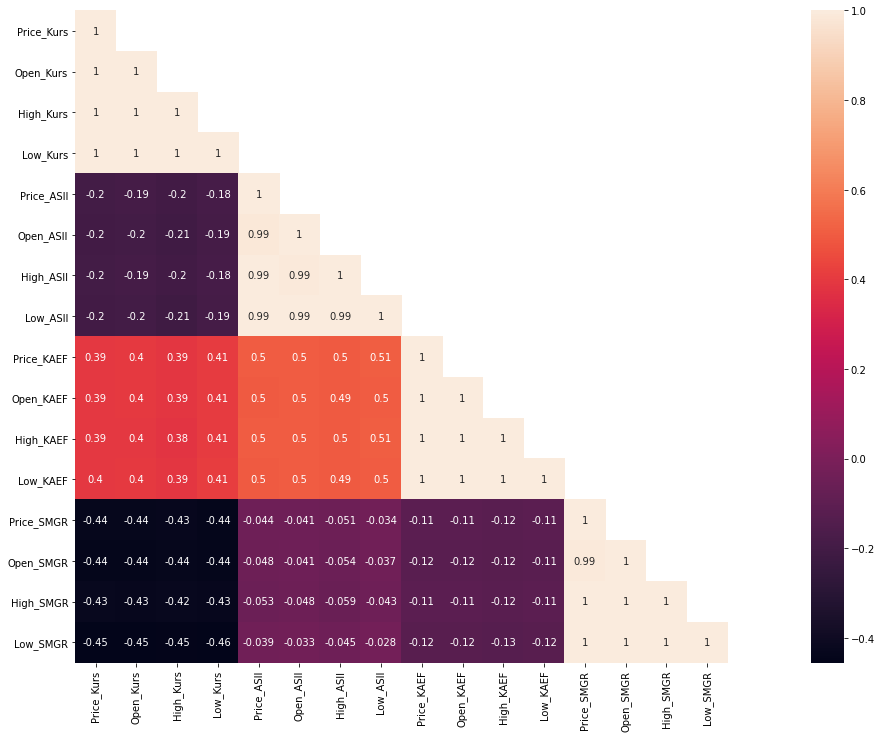

In [0]:
cor_mat = dataset_merge[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)


* **Stacked Line Plot for Looking the Trend**

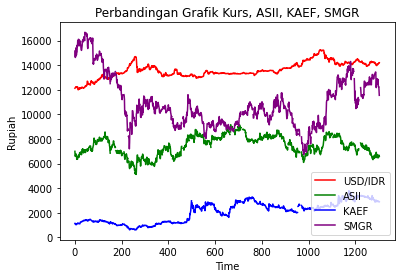

In [0]:
plt.plot(dataset_merge['Price_Kurs'], color = 'red', label = 'USD/IDR')
plt.plot(dataset_merge['Price_ASII'], color = 'green', label = 'ASII')
plt.plot(dataset_merge['Price_KAEF'], color = 'blue', label = 'KAEF')
plt.plot(dataset_merge['Price_SMGR'], color = 'purple', label = 'SMGR')
plt.title('Perbandingan Grafik Kurs, ASII, KAEF, SMGR')
plt.xlabel('Time')
plt.ylabel('Rupiah')
plt.legend()
plt.show()

# ***Pre-Processing - Feature Selection***

* **Open, High and Low can be Represented by Price Columns**

In [0]:
dataset_merge = dataset_merge.drop(['Open_Kurs', 'High_Kurs', 'Low_Kurs', 
                                    'Open_ASII', 'High_ASII', 'Low_ASII', 
                                    'Open_KAEF', 'High_KAEF', 'Low_KAEF', 
                                    'Open_SMGR', 'High_SMGR', 'Low_SMGR'], axis = 1)
dataset_merge

,Date,Price_Kurs,Price_ASII,Price_KAEF,Price_SMGR
0,"Oct 01, 2014",12127.5,7000.0,1145.0,15150.0
1,"Oct 02, 2014",12150.0,6600.0,1105.0,14700.0
2,"Oct 03, 2014",12176.5,6600.0,1070.0,14625.0
3,"Oct 06, 2014",12210.0,6725.0,1080.0,15050.0
4,"Oct 07, 2014",12202.5,6800.0,1065.0,15400.0
...,...,...,...,...,...
1299,"Sep 24, 2019",14112.5,6475.0,2940.0,12275.0
1300,"Sep 25, 2019",14150.0,6500.0,2910.0,12225.0
1301,"Sep 26, 2019",14177.5,6700.0,2930.0,12250.0
1302,"Sep 27, 2019",14165.0,6650.0,2920.0,11850.0


# ***Pre-Processing - Fill Missing Values***

* **Check Number of Missing Values**

In [0]:
dataset_merge.isnull().values.any()
dataset_merge.isnull().sum()

Date           0
Price_Kurs     0
Price_ASII    91
Price_KAEF    92
Price_SMGR    91
dtype: int64

* **Fill the Missing Values based on Previous Record**

In [0]:
dataset_merge = dataset_merge.fillna(method='ffill') #Based on Previous Record
dataset_merge.isnull().values.any()

False

# ***Pre-Processing - Split into Train/Test***

* **Determine the Test Proportion**

In [0]:
n_testProp = 0.3 #Adjustable

* **Start Spliting for Both Univariate and Multicariate Cases**

In [0]:
#Split Data Row Univariate - Price ASII Can be Change to: Price_KAEF, Price_SMGR
data_Univariate = dataset_merge.loc[:,['Price_ASII']] 
data_trainUni, data_testUni = train_test_split(data_Univariate, test_size=n_testProp, shuffle=False)
data_testUni = data_testUni.reset_index().iloc[:,1:2]
data_testActual = data_testUni

#Split Data Row Multivariate - Price ASII Can be Change to: Price_KAEF, Price_SMGR
data_Multivariate = dataset_merge.loc[:,['Price_Kurs', 'Price_ASII']]
data_trainMulti, data_testMulti = train_test_split(data_Multivariate, test_size=n_testProp, shuffle=False)
data_testMulti = data_testMulti.reset_index().iloc[:,1:3]
data_trainMultiKurs, data_trainMultiSaham = data_trainMulti.iloc[:,0:1], data_trainMulti.iloc[:,1:2]

print('Univariate | Train:Test Size  = ' +str(len(data_trainUni))+ ' : ' +str(len(data_testUni))+ 
      '\nMultivariate | Train:Test Size  = ' +str(len(data_trainMulti))+ ' : ' +str(len(data_testMulti)))

Univariate | Train:Test Size  = 912 : 392
Multivariate | Train:Test Size  = 912 : 392


# ***Pre-Processing - Feature Scaling***

* **Scaling Train Univariate**

In [0]:
sc = MinMaxScaler(feature_range = (0, 1)) 
data_trainUni = sc.fit_transform(data_trainUni)

for i in range(5): #Sampling 5 Row 
	print(data_trainUni[i]) #Merge for Check Data Structure

[0.46583851]
[0.36645963]
[0.36645963]
[0.39751553]
[0.41614907]


* **Scaling Train Multivariate using Different Scaler**

In [0]:
scI = MinMaxScaler(feature_range = (0, 1))
scD = MinMaxScaler(feature_range = (0, 1))
data_trainMultiKurs = scI.fit_transform(data_trainMultiKurs)
data_trainMultiSaham = scD.fit_transform(data_trainMultiSaham)

for i in range(5): #Sampling 5 Row 
	print(data_trainMultiKurs[i], data_trainMultiSaham[i])  #Merge for Check Data Structure

[0.04726599] [0.46583851]
[0.05560704] [0.36645963]
[0.06543095] [0.36645963]
[0.07784986] [0.39751553]
[0.07506951] [0.41614907]


# ***Pre-Processing - Build Data Structure***

* **Determine the Timestep, with Illustration**
![alt text](https://drive.google.com/uc?id=1igBCmcwPCyv2Q3D4mTS7NVAZd8RXWa0C)



In [0]:
n_timestep = 2 #Adjustable

* **Univariate Training Set Data Structure**

In [0]:
x_trainUni = [] #Univariate Predictor
y_trainUni = [] #Univariate Regresor
for i in range(n_timestep, len(data_trainUni)):
    x_trainUni.append(data_trainUni[i-n_timestep:i, 0])
    y_trainUni.append(data_trainUni [i, 0])
x_trainUni, y_trainUni = np.array(x_trainUni), np.array(y_trainUni)
x_trainUni = np.reshape(x_trainUni, (x_trainUni.shape[0], x_trainUni.shape[1], 1))

for i in range(5): #Sampling 5 Row  
	print(x_trainUni[i], y_trainUni[i]) #Merge for Check Data Structure

[[0.46583851]
 [0.36645963]] 0.36645962732919246
[[0.36645963]
 [0.36645963]] 0.39751552795031064
[[0.36645963]
 [0.39751553]] 0.4161490683229814
[[0.39751553]
 [0.41614907]] 0.3913043478260869
[[0.41614907]
 [0.39130435]] 0.39751552795031064


* **Multivariate Training Set Data Structure**

In [0]:
#Make one Cell consist of n_timestep
data_trainMultiHstack = hstack((data_trainMultiKurs, data_trainMultiSaham)) 

x_trainMulti = [] #Univariate Predictor
y_trainMulti = [] #Univariate Regresor
for i in range(n_timestep, len(data_trainMultiHstack)):
    x_trainMulti.append(data_trainMultiHstack[(i-n_timestep):i])
    y_trainMulti.append(data_trainMultiSaham[i,0])
x_trainMulti, y_trainMulti = np.array(x_trainMulti), np.array(y_trainMulti)

for i in range(5): #Sampling 5 Row 
	print(x_trainMulti[i], y_trainMulti[i]) #Merge for Check Data Structure

[[0.04726599 0.46583851]
 [0.05560704 0.36645963]] 0.36645962732919246
[[0.05560704 0.36645963]
 [0.06543095 0.36645963]] 0.39751552795031064
[[0.06543095 0.36645963]
 [0.07784986 0.39751553]] 0.4161490683229814
[[0.07784986 0.39751553]
 [0.07506951 0.41614907]] 0.3913043478260869
[[0.07506951 0.41614907]
 [0.08897127 0.39130435]] 0.39751552795031064


* **Univariate Test Set Data Structure**

In [0]:
inputs_uni = data_Univariate[len(data_Univariate) - len(data_testUni) - n_timestep:].values 
inputs_uni = sc.transform(inputs_uni)

x_testUni = [] #Univariate Predictor for Forecasting
for i in range(n_timestep, len(inputs_uni)): 
    x_testUni.append(inputs_uni[i-n_timestep:i, 0])
x_testUni = np.array(x_testUni)
x_testUni = np.reshape(x_testUni, (x_testUni.shape[0], x_testUni.shape[1], 1))

for i in range(5): #Sampling 5 Row 
	print(x_testUni[i]) #Merge for Check Data Structure

[[0.49068323]
 [0.54037267]]
[[0.54037267]
 [0.54037267]]
[[0.54037267]
 [0.60248447]]
[[0.60248447]
 [0.63354037]]
[[0.63354037]
 [0.60869565]]


* **Multivariate Test Set Data Structure**

In [0]:
inputs_multi = data_Multivariate[len(data_Multivariate) - len(data_testMulti) - n_timestep:].values
inputs_multi = pd.DataFrame(inputs_multi) 
inputs_multi.columns = ['Price_Kurs', 'Price_Saham']

data_testMultiKurs, data_testMultiSaham = inputs_multi.iloc[:,0:1], inputs_multi.iloc[:,1:2] 
data_testMultiKurs = scI.transform(data_testMultiKurs)
data_testMultiSaham = scD.transform(data_testMultiSaham)
data_testMultiHstack = hstack((data_testMultiKurs, data_testMultiSaham))

x_testMulti = [] #Multivariate Predictor for Forecasting
for i in range(n_timestep, len(inputs_multi)): 
    x_testMulti.append(data_testMultiHstack[i-n_timestep:i, : ])
x_testMulti = np.array(x_testMulti)
x_testMulti = x_testMulti.reshape((x_testMulti.shape[0], x_testMulti.shape[1], 2))

for i in range(5): #Sampling 5 Row 
	print(x_testMulti[i]) #Merge for Check Data Structure

[[0.65356812 0.49068323]
 [0.65430955 0.54037267]]
[[0.65430955 0.54037267]
 [0.65430955 0.54037267]]
[[0.65430955 0.54037267]
 [0.6502317  0.60248447]]
[[0.6502317  0.60248447]
 [0.65412419 0.63354037]]
[[0.65412419 0.63354037]
 [0.65486562 0.60869565]]


# ***Model Construction / Training***

* **Determine Adjustable Parameters into Variables**

In [0]:
n_DenseUnits = 1                #Since the Output are Consist of 1 Results
n_loss = 'mean_squared_error'   #Loss Function

# Given Value Parameters
n_LSTMunits = 10      #Adjustable : 10, 30, 50
n_DropoutRate = 0.1   #Adjustable : 0.1, 0.3, 0.5
n_optimizer = 'Adam'  #Adjustable : Adam, RMSprop, SGD
n_epoch = 50          #Adjustable : 50, 100, 150, 200
n_batchsize = 32      #Adjustable : 32, 64, 96

* **Build Univariate LSTM Models**

In [0]:
modelUni = Sequential()
modelUni.add(LSTM(units = n_LSTMunits, input_shape = (x_trainUni.shape[1], x_trainUni.shape[2])))
modelUni.add(Dropout(rate = n_DropoutRate))
modelUni.add(Dense(units = n_DenseUnits))
modelUni.compile(optimizer = n_optimizer, loss = n_loss)

#Record the Training Time & Last Loss in Model Construction
startTrain = time.perf_counter()
historyUni = modelUni.fit(x = x_trainUni, y = y_trainUni, epochs = n_epoch, batch_size = n_batchsize)
elapsedTrainUni = time.perf_counter() - startTrain
TTUni = '%.4f' % elapsedTrainUni
LastLossUni = '%.4f' % historyUni.history['loss'][-1]

Epoch 1/50
29/29 [==============================] - 0s 2ms/step - loss: 0.4275
Epoch 2/50
29/29 [==============================] - 0s 2ms/step - loss: 0.3283
Epoch 3/50
29/29 [==============================] - 0s 2ms/step - loss: 0.2352
Epoch 4/50
29/29 [==============================] - 0s 2ms/step - loss: 0.1551
Epoch 5/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0801
Epoch 6/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0377
Epoch 7/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0245
Epoch 8/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0224
Epoch 9/50
29/29 [==============================] - 0s 3ms/step - loss: 0.0202
Epoch 10/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 11/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 12/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 13/50
29/29 [==============================

* **Build Multivariate LSTM Models**

In [0]:
modelMulti = Sequential()
modelMulti.add(LSTM(units = n_LSTMunits, input_shape = (x_trainMulti.shape[1] , x_trainMulti.shape[2])))
modelMulti.add(Dropout(rate = n_DropoutRate))
modelMulti.add(Dense(units = n_DenseUnits))
modelMulti.compile(optimizer = n_optimizer, loss = n_loss)

#Record the Training Time & Last Loss in Model Construction
startTrain = time.perf_counter()
historyMulti = modelMulti.fit(x = x_trainMulti, y = y_trainMulti, epochs = n_epoch, batch_size = n_batchsize)
elapsedTrainMulti = time.perf_counter() - startTrain
TTMulti = '%.4f' % elapsedTrainMulti
LastLossMulti = '%.4f' % historyMulti.history['loss'][-1]

Epoch 1/50
29/29 [==============================] - 0s 2ms/step - loss: 0.3070
Epoch 2/50
29/29 [==============================] - 0s 2ms/step - loss: 0.1701
Epoch 3/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 4/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0417
Epoch 5/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0319
Epoch 6/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0281
Epoch 7/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0282
Epoch 8/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0250
Epoch 9/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch 10/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch 11/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 12/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 13/50
29/29 [==============================

* **Stacked Line Plot for See Training Loss**

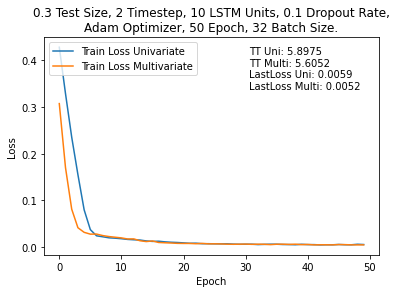

In [0]:
figLoss = plt.gcf()
plt.plot(historyUni.history['loss'])
plt.plot(historyMulti.history['loss'])
plt.title(str(n_testProp)+ ' Test Size, ' +str(n_timestep)+ ' Timestep, ' 
          +str(n_LSTMunits)+ ' LSTM Units, ' +str(n_DropoutRate)+ ' Dropout Rate,\n'
          +str(n_optimizer)+ ' Optimizer, ' +str(n_epoch)+ ' Epoch, ' 
          +str(n_batchsize)+ ' Batch Size.')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figtext(0.60, 0.70, "TT Uni: " +str(TTUni)+ "\nTT Multi: " +str(TTMulti)+ 
            "\nLastLoss Uni: " +str(LastLossUni)+ "\nLastLoss Multi: " +str(LastLossMulti))
plt.legend(['Train Loss Univariate', 'Train Loss Multivariate'], loc='upper left')
plt.show()

#Save Image of Plot for Training Loss
figLoss.savefig(pathResults +str(n_testProp)+ ' Test Size, ' +str(n_timestep)+ ' Timestep, ' 
                +str(n_LSTMunits)+ ' LSTM Units, ' +str(n_DropoutRate)+ ' Dropout Rate, '
                +str(n_optimizer)+ ' Optimizer, ' +str(n_epoch)+ ' Epoch, ' 
                +str(n_batchsize)+ ' Batch Size - Training Loss.png', dpi = 100)

# ***Model Prediction / Testing***

* **Forecast with Univariate LSTM Models**

In [0]:
y_testUni = modelUni.predict(x_testUni)
data_testPredUni = sc.inverse_transform(y_testUni)      #Denormalization <> Scaling

* **Forecast with Multivariate LSTM Models**

In [0]:
y_testMulti = modelMulti.predict(x_testMulti) 
data_testPredMulti = scD.inverse_transform(y_testMulti) #Denormalization <> Scaling

* **Combine and Save Result to Variable for Recaps in Excel**


In [0]:
A_PredictionResult = np.hstack([data_testPredUni,data_testPredMulti])
A_PredictionResult = np.around(A_PredictionResult, decimals=2, out=None)
A_PredictionResult = A_PredictionResult.astype(str)     #Array String - Results Comma

# ***Model Evaluation***

* **Mean Absolute Percentage Error Calculation Function**


In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPEUni = '%.4f' % mean_absolute_percentage_error(data_testUni, data_testPredUni)         #Univariate
MAPEMulti = '%.4f' % mean_absolute_percentage_error(data_testActual, data_testPredMulti)  #Multivariate

* **Stacked Line Plot for See Forecast Result & Evaluation**

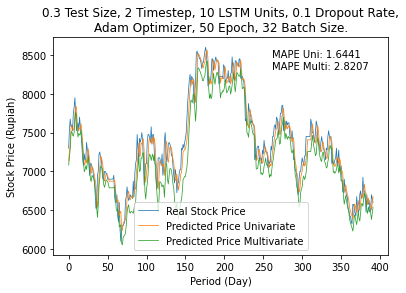

In [0]:
figPredict = plt.gcf()
plt.plot(data_testActual, label = 'Real Stock Price', linewidth=0.75)
plt.plot(data_testPredUni, label = 'Predicted Price Univariate', linewidth=0.75)
plt.plot(data_testPredMulti, label = 'Predicted Price Multivariate', linewidth=0.75)
plt.title(str(n_testProp)+ ' Test Size, ' +str(n_timestep)+ ' Timestep, ' 
          +str(n_LSTMunits)+ ' LSTM Units, ' +str(n_DropoutRate)+ ' Dropout Rate,\n'
          +str(n_optimizer)+ ' Optimizer, ' +str(n_epoch)+ ' Epoch, ' 
          +str(n_batchsize)+ ' Batch Size.')
plt.xlabel('Period (Day)')
plt.ylabel('Stock Price (Rupiah)')
plt.figtext(0.63, 0.77, "MAPE Uni: " +str(MAPEUni)+ "\nMAPE Multi: " +str(MAPEMulti))
plt.legend()
plt.show()

#Save Image of Plot for Forecasting Visualization
figPredict.savefig(pathResults +str(n_testProp)+ ' Test Size, ' +str(n_timestep)+ ' Timestep, ' 
                   +str(n_LSTMunits)+ ' LSTM Units, ' +str(n_DropoutRate)+ ' Dropout Rate, '
                   +str(n_optimizer)+ ' Optimizer, ' +str(n_epoch)+ ' Epoch, ' 
                   +str(n_batchsize)+ ' Batch Size - Testing Result.png', dpi = 100)

# ***Save Forecasting Results***

* **Result Summary**

In [0]:
something = "\n=================================\n"
print(something + "RECAP RESULT (MAPE, TT, LastLoss)" + something)
print(str(n_testProp)+ ' Test Size, ' +str(n_timestep)+ ' Timestep, ' 
      +str(n_LSTMunits)+ ' LSTM Units, ' +str(n_DropoutRate)+ ' Dropout Rate,'
      +str(n_optimizer)+ ' Optimizer, ' +str(n_epoch)+ ' Epoch, ' 
      +str(n_batchsize)+ ' Batch Size\n')
print("— Univariate Model:")
print("MAPE\t\t= " +MAPEUni+ "\nTraining Time\t= " +TTUni+ "\nLastLoss\t= " +LastLossUni+ "\n")
print("— Multivariate Model:")
print("MAPE\t\t= " +MAPEMulti+ "\nTraining Time\t= " +TTMulti + "\nLastLoss\t= " +LastLossMulti+ "\n")


RECAP RESULT (MAPE, TT, LastLoss)

0.3 Test Size, 2 Timestep, 10 LSTM Units, 0.1 Dropout Rate,Adam Optimizer, 50 Epoch, 32 Batch Size

— Univariate Model:
MAPE		= 1.6441
Training Time	= 5.8975
LastLoss	= 0.0059

— Multivariate Model:
MAPE		= 2.8207
Training Time	= 5.6052
LastLoss	= 0.0052



* **Save Forecasting Result like Expected Format**

![alt text](https://drive.google.com/uc?id=10AnB3MqGTe9sEma29TzMvmxsv1ufU0zY)



In [0]:
#Merge with Univariate-Multivariate Format
A_EvaluationResult = [[MAPEUni, MAPEMulti], [TTUni, TTMulti], [LastLossUni, LastLossMulti]]
A_EvaluationResult = np.asarray(A_EvaluationResult) #Array String

#Desired Format
A_AnExcelResult = np.concatenate((A_EvaluationResult, A_PredictionResult), axis=0)

#Set to Dataframe
A_AnExcelResult = pd.DataFrame(A_AnExcelResult)
A_AnExcelResult.columns = ['Univariate', 'Multivariate']

#Make the Value in a Cell in Auto Number Format (Excel)
A_AnExcelResult.Univariate = A_AnExcelResult.Univariate.str.replace('.', ',')     
A_AnExcelResult.Multivariate = A_AnExcelResult.Multivariate.str.replace('.', ',')

A_AnExcelResult.to_excel(pathResults +str(n_testProp)+ ' Test Size, ' +str(n_timestep)+ ' Timestep, ' 
                         +str(n_LSTMunits)+ ' LSTM Units, ' +str(n_DropoutRate)+ ' Dropout Rate, ' 
                         +str(n_optimizer)+ ' Optimizer, ' +str(n_epoch)+ ' Epoch, ' 
                         +str(n_batchsize)+ ' Batch Size - Eval & Predict Excel.xlsx', 
                         index = False, header = False)